In [149]:
#############################################################################################################
### Python classifier based on k-NNFP algorithm (k nearest neighbours on features projection)             ###
#############################################################################################################
#
# The fit() function just stores training data as is
# 
# The predict() function uses the k-nnfp algorithm to return the classes of the data passed as a parameter
# by doing a majority voting for the classes found for each neighbour, according to each individual feature.
#
# In other words, it's like doing k-NN on each individual feature with a majority voting at the end
# to determine the class.
#
# The classifier expects classes to be numbered from 0 to n.
# 
# Furthermore, it expects that missing data be of type np.nan in order to avoid them correctly,
# so you should convert your dataset accordingly (i.e. replace ? with np.nan for example)
#
#############################################################################################################

"""
Extract from http://nimbusvault.net/publications/koala/assr/papers/k17is-223.pdf :

K-Nearest Neighbors on Feature Projections algorithm (k-NNFP):
The K-Nearest Neighbors on Feature Projections (k-NNFP) algorithm is an alternative approach of the
state-of-the-art k-NN classification process. This approach is based on extracted votes applied on a set of
classes, which derive after k-NN performance in each feature separately of the unclassified example.
The most important characteristic of this classification algorithm is that the training set is stored as an
equivalent projection set on feature space. In the dataset that is delivered below in Table 1 three training
examples with two features and a class feature per example is presented.

----------------------------------
Training Example  f0  f1  Class
   Example 1      1   6     B
   Example 2      4   3     A
   Example 3     10   5     A
----------------------------------
Table 1. Training Examples
----------------------------------

The k-NNFP algorithm classifies a given unclassified examples as follows. Firstly,
the k-closest training examples are calculated for each feature, and their classes
are stored, separately. In the next step, the sum of each class is calculated in

feature storage space. Finally, the class with the max sum is performed to be the
class of the unclassified example.
In example, given an unclassified example (<3, 2>), where f0 = 3, f1 = 2 and the
label class is unknown, the k-NNFP approach classifies the example to the ‘A’
class for k = 1 and k = 2, as it is presented in Table 2:

-----------------------------------------------------------------
k   f0      f1     Features’ Bag   Class
1  [A]      [A]      [A, A]          A
2 [A, B]  [A, A]  [A, B, A, A]       A
-----------------------------------------------------------------
Table 2. K-NNFP classification for unclassified example (<3, 2>)
-----------------------------------------------------------------

Considering their differences and the similarities, the k-NN approach focuses on
the distances between training dataset and unclassified examples that provide the
outcome classification on feature space, in opposite with the k-NNFP approach,
which is mainly focused on each feature contribution to the classification process
via the majority of feature votes.
"""

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
import numpy as np

# Based on a sklearn default classifier template
class kNNFPClassifier(ClassifierMixin, BaseEstimator):

    def __init__(self, n_neighbours=1):
        self.n_neighbours = n_neighbours

    def fit(self, X, y):
        # Check that X and y have correct shape
        # Commented because we do accept NaN values... they are handled later on in the code below
        # Another possibility would be to impute missing values (mean, median, ...)
        
        #X, y = check_X_y(X, y) 
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y

        # Return the classifier
        return self
    
    def predict(self, X):
        # Check is fit had been called
        # Commented because we do accept NaN values... they are handled later on in the code below
        
        #check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        # Commented because we do accept NaN values... they are handled later on in the code below.
        
        #X = check_array(X) 
        
        # Array containing the classes found at the end of the algorithm for every tested instance
        # (every line of array passed in parameter)
        found_class = np.zeros(X.shape[0])
        # Iterating on all the lines of X (all the instances to be classified)
        for instance_index in range(X.shape[0]) :
            # To store the classes of the features for the n_neighbours neighbours
            neigbours_features_classes = np.zeros((self.n_neighbours, X.shape[1]))
            # Iterating on X transposed, so on the columns (features) of the train data
            for column in range(len(self.X_.T)) :
                # Initialize the array of the already found neighbours with -1 values
                # (no neighbours at the moment)
                already_found_neighbours_rows = [-1]*self.n_neighbours
                # We want to find n_neighbours neighbours
                for neighbour_index in range(self.n_neighbours) :
                    # For every new neighbours we seek, we initialize the closest value at the max possible
                    # distance (max possible value for a float64) : every new neighbours found has to be
                    # closer than that.
                    closest = np.finfo(np.float64).max
                    # Iterating on all the train data to look for neighbours
                    for row in range(len(self.X_)) :
                        # We only check for lines which have not already been picked as neighbours
                        if row not in already_found_neighbours_rows :
                            # We are only testing the distances if the data exist (not NaN)
                            if (np.isnan(X[instance_index][column]) == False) & (np.isnan(self.X_[row][column]) == False) :
                                # Computes the distance between the current feature from X and the feature of
                                # the train data of the current iteration
                                distance = abs(X[instance_index][column] - self.X_[row][column])
                                # If we find a closer one... 
                                if distance < closest :
                                    # ...we store its value as the closest known
                                    closest = distance
                                    # Store the class of this new closest
                                    neigbours_features_classes[neighbour_index][column] = self.y_[row]
                                    # Mark the row of this new neighbour as already selected
                                    # (we don't want to parse it again in next iterations)
                                    already_found_neighbours_rows[neighbour_index] = row
            # Flatten the class array in order to apply majority voting
            neigbours_features_classes = neigbours_features_classes.flatten()
            # Cast as a numpy array for majority voting
            neigbours_features_classes = np.array(neigbours_features_classes).astype(int)
            # Counting the bins of every class
            counts = np.bincount(neigbours_features_classes)
            # Majority voting to determine the class
            found_class[instance_index] = np.argmax(counts)

        return found_class


In [3]:
# Test on Iris dataset
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer

iris = datasets.load_iris()
irisdata = iris.data
irisclasses = iris.target

# Create train and test datasets to evaluate generalization performance of the model
# No need to stratify here because the dataset is balanced (50 samples for each of the 3 classes)
# random_state fixed for reproductibility
X_train, X_test, y_train, y_test = train_test_split(irisdata, irisclasses, test_size=0.3, shuffle=True, random_state=9)

knnfp_classifier = kNNFPClassifier(15)
knnfp_classifier.fit(X_train, y_train)

# Here regular cross_val is acceptable because the dataset is balanced
scores = cross_val_score(knnfp_classifier, X_train, y_train, cv=5)
print(f"scores cross_val: {scores}")
print(f"Accuracy: {scores.mean()} +/- {scores.std()}*2")

scores cross_val: [0.85714286 0.9047619  0.95238095 0.85714286 1.        ]
Accuracy: 0.9142857142857143 +/- 0.05553287518900288*2


In [4]:
# Final evaluation on the test set
# We should keep in mind that a randomly chosen test set will produce high variance in the results
# if train/test split + eval is repeated, as compared with cross-validation.
y_pred = knnfp_classifier.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 1.0


In [5]:
### Comparison with classic k-NN algorithm

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

scores = cross_val_score(knn, X_train, y_train, cv=5)
print(f"scores cross_val: {scores}")
print(f"Accuracy: {scores.mean()} +/- {scores.std()}*2")

y_pred = knn.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

scores cross_val: [0.95238095 0.9047619  0.95238095 0.9047619  1.        ]
Accuracy: 0.9428571428571427 +/- 0.03563483225498991*2
Test Accuracy: 1.0


In [12]:
### k-NN seems to work slightly better on this dataset if we look at the cross-validation results

In [14]:
!pip install ucimlrepo

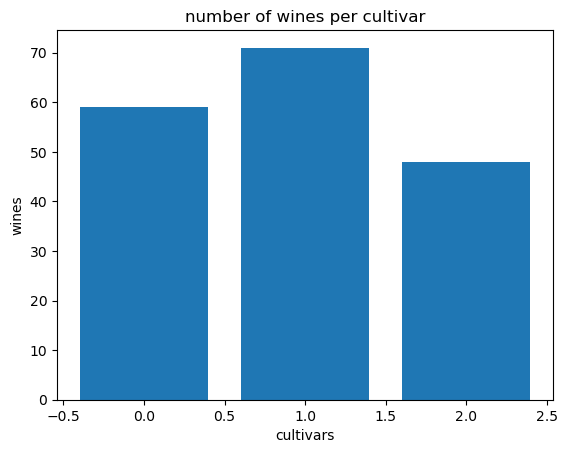

In [4]:
### Test k-NNFP on the Wine dataset (UCI) : predict the origin (cultivar) of wines basing on their
### chemical composition

from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt

# Fetch dataset 
wine = fetch_ucirepo(id=109) 
  
# Data (as pandas dataframes) 
X = wine.data.features 
y = wine.data.targets 

# Converts the dataframe into a numpy array, and stores the classes in a separate np array
X = X.to_numpy()
X = np.array(X).astype(float)
y = y.to_numpy()
y = np.array(y).astype(int)
y = y.ravel() #Converts the classes in scikit-learn format (1d list)

# Changes the range of classes to be 0 to n (instead of 1 to n)
y = y - np.array([1]*y.shape[0])

# Display the number of members of each class in a bar graph
unique, counts = np.unique(y, return_counts=True)
index = unique #range(3,9) # il y a 10 notes possibles
plt.bar(index, counts)
plt.xlabel('cultivars', fontsize=10)
plt.ylabel('wines', fontsize=10)
plt.title('number of wines per cultivar')
plt.show()

In [5]:
# Random shuffling to avoid a (possible) pre-existing ordering in the data
X, y = shuffle(X, y, random_state=9)

# Create train and test datasets to evaluate generalization performance of the model
# Doing stratify here because of imbalanced dataset
# random_state fixed for reproductibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=9)

knnfp_classifier = kNNFPClassifier(5)

# Appart from evaluating on a separate test set, we also do cross-validation for estimation of model perf.
# Since the dataset is imbalanced, we use StratifiedKFold cross-validation.
# This cross-validation is performed on the X_train set and not on the whole dataset, in order to be
# consistent with the final evaluation on test set, which uses X_train for training too.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=9)
accuracies_stratified = []
  
for train_index, test_index in skf.split(X_train, y_train):
    x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    knnfp_classifier.fit(x_train_fold, y_train_fold)
    y_pred = knnfp_classifier.predict(x_test_fold)
    accuracies_stratified.append(accuracy_score(y_test_fold, y_pred))

print('List of possible accuracies:', accuracies_stratified)
print('\nMaximum Accuracy that can be obtained from this model:', max(accuracies_stratified)*100, '%')
print('\nMinimum Accuracy:', min(accuracies_stratified)*100, '%')
print('\nOverall Accuracy:', np.mean(accuracies_stratified)*100, '%')
print('\nStandard Deviation is:', np.std(accuracies_stratified))

List of possible accuracies: [0.9655172413793104, 1.0, 0.9285714285714286, 0.9642857142857143, 0.9642857142857143]

Maximum Accuracy that can be obtained from this model: 100.0 %

Minimum Accuracy: 92.85714285714286 %

Overall Accuracy: 96.45320197044336 %

Standard Deviation is: 0.022593068562499746


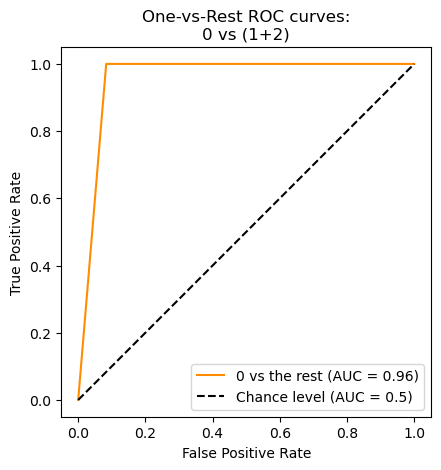

In [39]:
# One-vs-Rest multiclass ROC : https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
from sklearn.preprocessing import LabelBinarizer

#In this section we use a LabelBinarizer to binarize the target by one-hot-encoding in a OvR fashion.
#This means that the target of shape (n_samples,) is mapped to a target of shape (n_samples, n_classes).
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
# y_onehot_test.shape  # (n_samples, n_classes). here : (36, 3)

# Preparing ROC OvR : class 0 vs classes 1+2
class_of_interest = 0 # could be "virginica" for iris dataset
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

# Predicts the classes on the test set, and one-hot-encode them
knnfp_classifier.fit(X_train, y_train)
y_pred = knnfp_classifier.predict(X_test)
y_pred = label_binarizer.transform(y_pred)

# Draw ROC curve
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_pred[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n0 vs (1+2)")
plt.legend()
plt.show()

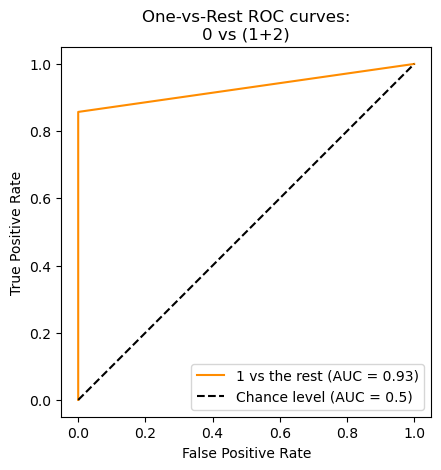

In [42]:
# Preparing ROC OvR : class 1 vs classes 0+2
class_of_interest = 1 # could be "virginica" for iris dataset
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

# Draw ROC curve
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_pred[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n1 vs (0+2)")
plt.legend()
plt.show()

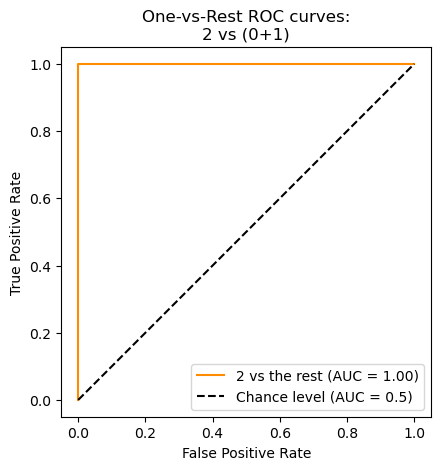

In [43]:
# Preparing ROC OvR : class 2 vs classes 0+1
class_of_interest = 2 # could be "virginica" for iris dataset
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

# Draw ROC curve
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_pred[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n2 vs (0+1)")
plt.legend()
plt.show()

In [18]:
# Final evaluation on the test set
# We should keep in mind that a randomly chosen test set will produce high variance in the results
# if train/test split + eval is repeated, as compared with cross-validation.
knnfp_classifier.fit(X_train, y_train)
y_pred = knnfp_classifier.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.9444444444444444


In [84]:
### Comparison with classic k-NN algorithm

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=9)
accuracies_stratified = []
  
for train_index, test_index in skf.split(X_train, y_train):
    x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    knn.fit(x_train_fold, y_train_fold)
    y_pred = knn.predict(x_test_fold)
    accuracies_stratified.append(accuracy_score(y_test_fold, y_pred))

print('List of possible accuracies:', accuracies_stratified)
print('\nMaximum Accuracy that can be obtained from this model:', max(accuracies_stratified)*100, '%')
print('\nMinimum Accuracy:', min(accuracies_stratified)*100, '%')
print('\nOverall Accuracy:', np.mean(accuracies_stratified)*100, '%')
print('\nStandard Deviation is:', np.std(accuracies_stratified))

List of possible accuracies: [0.6551724137931034, 0.7241379310344828, 0.5, 0.6428571428571429, 0.75]

Maximum Accuracy that can be obtained from this model: 75.0 %

Minimum Accuracy: 50.0 %

Overall Accuracy: 65.44334975369458 %

Standard Deviation is: 0.08715036154673549


In [86]:
# Final evaluation on the test set
# We should keep in mind that a randomly chosen test set will produce high variance in the results
# if train/test split + eval is repeated, as compared with cross-validation.
y_pred = knn.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.6944444444444444


In [8]:
### On this dataset, k-NNFP works much better than k-NN based on cross-validation and test set eval

In [19]:
### Test on the Dermatology dataset (UCI) : skin disease diagnostic (classification task)

col_list = [*range(0,34,1)]
data_frame = pd.read_csv("./datasets/DermatologyDataset/dermatology.data", sep=",", header=None, usecols=col_list, encoding ='latin1')

col_list = [34]
classes = pd.read_csv("./datasets/DermatologyDataset/dermatology.data", sep=",", header=None, usecols=col_list, encoding ='latin1')

# Replace missing values with np.nan (which our classifier handles)
data_frame.replace('?',np.nan, inplace=True)

# Converts the dataframe into a numpy array, and stores the classes in a separate np array
dermato_data = data_frame.to_numpy()
dermato_data = np.array(dermato_data).astype(float)
dermato_classes = classes.to_numpy()
dermato_classes = np.array(dermato_classes).astype(int)
dermato_classes = dermato_classes.ravel() #met les classes sous la forme demandée par scikit-learn (liste 1d)

# Changes the range of classes to be 0 to n (instead of 1 to n)
dermato_classes = dermato_classes - np.array([1]*dermato_classes.shape[0])

In [103]:
# Create train and test datasets to evaluate generalization performance of the model
# Doing stratify here because of imbalanced dataset
# random_state fixed for reproductibility

# Random shuffling to avoid a (possible) pre-existing ordering in the data
dermato_data, dermato_classes = shuffle(dermato_data, dermato_classes, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(dermato_data, dermato_classes, stratify=dermato_classes, test_size=0.2, random_state=0)

# Doing imputation by the mean, because we also need to do this for k-NN algorithm comparison.
# So we want the datasets to be equal for comparing both algorithms.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)
X_train_imputed = imp.transform(X_train)
imp.fit(X_test)
X_test_imputed = imp.transform(X_test)

# Appart from evaluating on a separate test set, we also do cross-validation for estimation of model perf.
# Since the dataset is imbalanced, we use StratifiedKFold cross-validation.
# This cross-validation is performed on the X_train set and not on the whole dataset, in order to be
# consistent with the final evaluation on test set, which uses X_train for training too.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=9)
accuracies_stratified = []

for train_index, test_index in skf.split(X_train_imputed, y_train):
    x_train_fold, x_test_fold = X_train_imputed[train_index], X_train_imputed[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    knnfp_classifier.fit(x_train_fold, y_train_fold)s
    y_pred = knnfp_classifier.predict(x_test_fold)
    accuracies_stratified.append(accuracy_score(y_test_fold, y_pred))

print('List of possible accuracies:', accuracies_stratified)
print('\nMaximum Accuracy that can be obtained from this model:', max(accuracies_stratified)*100, '%')
print('\nMinimum Accuracy:', min(accuracies_stratified)*100, '%')
print('\nOverall Accuracy:', np.mean(accuracies_stratified)*100, '%')
print('\nStandard Deviation is:', np.std(accuracies_stratified))

List of possible accuracies: [0.7627118644067796, 0.4915254237288136, 0.8448275862068966, 0.5689655172413793, 0.5862068965517241]

Maximum Accuracy that can be obtained from this model: 84.48275862068965 %

Minimum Accuracy: 49.152542372881356 %

Overall Accuracy: 65.08474576271188 %

Standard Deviation is: 0.1314598802456178


In [104]:
# Final evaluation on the test set
# We should keep in mind that a randomly chosen test set will produce high variance in the results
# if train/test split + eval is repeated, as compared with cross-validation.
knnfp_classifier = kNNFPClassifier(5)
knnfp_classifier.fit(X_train_imputed, y_train)

y_pred = knnfp_classifier.predict(X_test_imputed)
print(f"test accuracy: {accuracy_score(y_test, y_pred)}")

test accuracy: 0.5945945945945946


In [105]:
### Comparing with classic k-NN algorithm
### Imputing missing data by the mean: necessary because knn doesn't accept missing values.

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)
X_train_imputed = imp.transform(X_train)
imp.fit(X_test)
X_test_imputed = imp.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_imputed, y_train)

scores = cross_val_score(knn, X_train_imputed, y_train, cv=5)
print(f"scores cross_val: {scores}")
print(f"Accuracy: {scores.mean()} +/- {scores.std()}*2")

scores cross_val: [0.88135593 0.81355932 0.89655172 0.82758621 0.86206897]
Accuracy: 0.8562244301578025 +/- 0.031408600450133016*2


In [106]:
y_pred = knn.predict(X_test_imputed)
print(f"MAE: {mean_absolute_error(y_test,y_pred)}")
print(f"test accuracy: {accuracy_score(y_test, y_pred)}")

MAE: 0.3783783783783784
test accuracy: 0.8783783783783784


In [195]:
### Bad results for k-NNFP on this dataset...

In [109]:
# Test on the Arrythmia dataset (UCI)

col_list = [*range(0,279,1)]
data_frame = pd.read_csv("./datasets/ArrhythmiaDataset/arrhythmia.data", sep=",", header=None, usecols=col_list, encoding ='latin1')

col_list = [279]
classes = pd.read_csv("./datasets/ArrhythmiaDataset/arrhythmia.data", sep=",", header=None, usecols=col_list, encoding ='latin1')

# Replace missing values with np.nan (which our classifier handles)
data_frame.replace('?',np.nan, inplace=True)

# Converts the dataframe into a numpy array, and stores the classes in a separate np array
arrythm_data = data_frame.to_numpy()
arrythm_data = np.array(arrythm_data).astype(float)
arrythm_classes = classes.to_numpy()
arrythm_classes = np.array(arrythm_classes).astype(int)
arrythm_classes = arrythm_classes.ravel() #met les classes sous la forme demandée par scikit-learn (liste 1d)

# Changes the range of classes to be 0 to n (instead of 1 to n)
arrythm_classes = arrythm_classes - np.array([1]*arrythm_classes.shape[0])

In [110]:
# Create train and test datasets to evaluate generalization performance of the model
# random_state fixed for reproductibility

# Random shuffling to avoid a (possible) pre-existing ordering in the data
arrythm_data, arrythm_classes = shuffle(arrythm_data, arrythm_classes, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(arrythm_data, arrythm_classes, stratify=arrythm_classes, test_size=0.3)

# Doing imputation by the mean, because we also need to do this for k-NN algorithm comparison.
# So we want the datasets to be equal for comparing both algorithms.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)
X_train_imputed = imp.transform(X_train)
imp.fit(X_test)
X_test_imputed = imp.transform(X_test)

knnfp_classifier = kNNFPClassifier(5)

# Appart from evaluating on a separate test set, we also do cross-validation for estimation of model perf.
# Since the dataset is imbalanced, we use StratifiedKFold cross-validation.
# This cross-validation is performed on the X_train set and not on the whole dataset, in order to be
# consistent with the final evaluation on test set, which uses X_train for training too.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=9)
accuracies_stratified = []

for train_index, test_index in skf.split(X_train_imputed, y_train):
    x_train_fold, x_test_fold = X_train_imputed[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    knnfp_classifier.fit(x_train_fold, y_train_fold)
    y_pred = knnfp_classifier.predict(x_test_fold)
    accuracies_stratified.append(accuracy_score(y_test_fold, y_pred))

print('List of possible accuracies:', accuracies_stratified)
print('\nMaximum Accuracy that can be obtained from this model:', max(accuracies_stratified)*100, '%')
print('\nMinimum Accuracy:', min(accuracies_stratified)*100, '%')
print('\nOverall Accuracy:', np.mean(accuracies_stratified)*100, '%')
print('\nStandard Deviation is:', np.std(accuracies_stratified))

/home/micmac/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


List of possible accuracies: [0.546875, 0.5396825396825397, 0.5396825396825397, 0.5396825396825397, 0.5396825396825397]

Maximum Accuracy that can be obtained from this model: 54.6875 %

Minimum Accuracy: 53.96825396825397 %

Overall Accuracy: 54.11210317460316 %

Standard Deviation is: 0.0028769841269841393


In [111]:
# Final evaluation on the test set
# We should keep in mind that a randomly chosen test set will produce high variance in the results
# if train/test split + eval is repeated, as compared with cross-validation.
knnfp_classifier.fit(X_train, y_train)
y_pred = knnfp_classifier.predict(X_test_imputed)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.5441176470588235


In [143]:
### Bad score on this dataset, but there are under-populated classes (1, 2, or 3 members)
### and a majoritary class (more than 200 members)


In [34]:
# Changes the width of Jupyter-Lab notebook
from IPython.core.display import display, HTML
display(HTML("<style>.jp-Cell { width: 80% !important; }</style>"))

/tmp/ipykernel_6253/4179403743.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
